In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.CIFAR10(root="Data",train=True,download=True,transform=transform)

Files already downloaded and verified


In [7]:
test_data = datasets.CIFAR10(root="Data",train=False,download=True,transform=transform)

Files already downloaded and verified


In [8]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [11]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


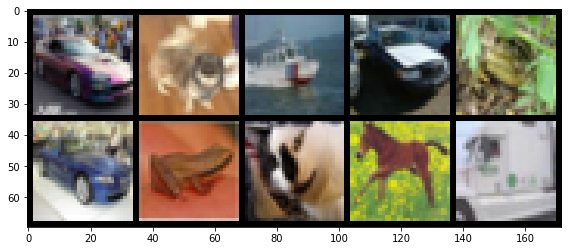

In [12]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16,120)        
        self.fc2 = nn.Linear(120,84)  
        self.fc3 = nn.Linear(84,10)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*6*6)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [19]:
torch.manual_seed(101)
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
for param in model.parameters():
  print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [22]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed     

epoch:  0  batch:  600 [  6000/60000]  loss: 1.88448274  accuracy:  22.950%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 1.57656217  accuracy:  28.042%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.95802420  accuracy:  31.650%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 1.55930448  accuracy:  33.938%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.99098176  accuracy:  35.850%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 1.91992736  accuracy:  37.372%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 1.18091440  accuracy:  38.538%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 1.24752879  accuracy:  39.800%
epoch:  1  batch:  600 [  6000/60000]  loss: 2.10914874  accuracy:  50.600%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 1.41718948  accuracy:  50.308%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 1.52077067  accuracy:  50.439%
epoch:  1  batch: 2400 [ 24000/60000]  loss: 1.16674912  accuracy:  50.996%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 1.31840956  accuracy:  51.263%
epoch:  1  b

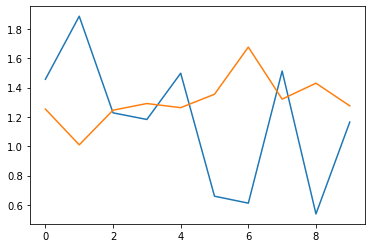

In [23]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "test loss")

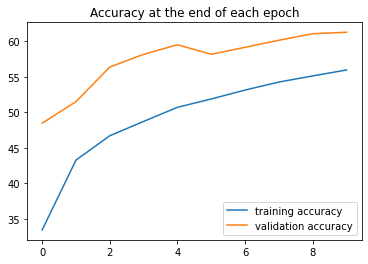

In [24]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [25]:
with torch.no_grad():
  accuracy = []
  for b,(features,labels) in enumerate(test_loader):
    logits = model(features)
    y_pred = logits.argmax(dim=1)
    acc = accuracy_score(y_pred,labels)
    accuracy.append(acc)


In [26]:
acc = sum(accuracy)/len(accuracy)
print("Accuracy is {:.2f}%".format(acc*100))

Accuracy is 61.25%
